In [120]:
import tensorflow as tf
import tensorflow_probability as tfp
from flowpm.cosmology import Planck15
import numpy as np
import flowpm
from flowpm.utils import r2c2d, c2r2d
from flowpm.tfpower import linear_matter_power
from itertools import cycle
import  DifferentiableHOS as DHOS

In [2]:
# Below are a few parameters
n_lens = 22       # Number of lensplanes in the lightcone
box_size = 100.   # Transverse comoving size of the simulation volume
nc = 128          # Number of transverse voxels in the simulation volume
field_size = 5    # Size of the lensing field in degrees
field_npix = 512  # Number of pixels in the lensing field
batch_size = 1    # Number of simulations to run in parallel

In [3]:
# Instantiates a cosmology with desired parameters
cosmology = Planck15()

In [4]:
# Schedule the center of the lensplanes we want for ray tracing
r = tf.linspace(0., box_size*n_lens, n_lens+1)
r_center = 0.5*(r[1:] + r[:-1]) # the position of each lens plans 

# Retrieve the scale factor corresponding to these distances
a = flowpm.tfbackground.a_of_chi(cosmology, r)
a_center =flowpm.tfbackground.a_of_chi(cosmology, r_center)

In [5]:
# this should be the redshift of our last lens
1/a[-1] - 1

<tf.Tensor: shape=(), dtype=float32, numpy=0.94021237>

In [6]:
# We run 4 steps from initial scale factor to start of raytracing
init_stages = tf.linspace(0.1, a[-1], 4)
# Then one step per lens plane
stages = tf.concat([init_stages, a_center.numpy()[::-1]], axis=0)

In [7]:
# Create some initial conditions
initial_conditions = flowpm.linear_field([nc, nc, nc],
                                         [box_size, box_size, box_size], 
                                         lambda k: tf.cast(linear_matter_power(cosmology, k), tf.complex64),         
                                         batch_size=batch_size)
initial_state = flowpm.lpt_init(cosmology, initial_conditions, 0.1)

In [8]:
# Run the Nbody
states = flowpm.nbody(cosmology, 
                      initial_state, 
                      stages,
                      [nc, nc, nc],
                      return_intermediate_states=True) 

In [ ]:
states[::-1][0][1][0]
#we have a list with 25 states
#[::-1]= invert the list ; 
# [0] take the first state of this reversed list( corresponds a_center=0.9832467)
#in each state we have a list of 2 elements, the a_center value and the physical features of the particles
#[1] take the second list, that describes the physical properties of each particles 
#we have now a tensor with shape=(3, 1, 2097152, 3)
#[0] take the position of each particales, for x,y,z

In [9]:
lensplanes = []
matrix=flowpm.raytracing.generate_matrix()
for i,j in zip(range(len(a_center)),cycle(range(6))):
    plane = flowpm.raytracing.density_plane(states[::-1][i][1],
                                            [nc, nc, nc],
                                            nc//2, #r_center[i]/box_size*nc,
                                            matrix[j],
                                            flowpm.raytracing.shift(),
                                            width=nc,
                                            plane_resolution=256)

    plane = tf.expand_dims(plane, axis=-1)
    lensplanes.append((r_center[i], states[::-1][i][0], plane[...,0]))
  

In [10]:
import astropy.units as u
xgrid, ygrid = np.meshgrid(np.linspace(0, field_size, field_npix, endpoint=False), # range of X coordinates
                           np.linspace(0, field_size, field_npix, endpoint=False)) # range of Y coordinates

coords = np.stack([xgrid, ygrid], axis=0)*u.deg
c = coords.reshape([2, -1]).T.to(u.rad)

In [11]:
z_source = tf.linspace(0.5, 1, 4)

In [12]:
m = flowpm.raytracing.convergenceBorn(cosmology, 
                    lensplanes, 
                    dx=box_size/256, 
                    dz=box_size,
                    coords=c,
                    z_source=z_source)

m = m.numpy().reshape([batch_size, field_npix, field_npix, -1])

In [13]:
m.shape

(1, 512, 512, 4)

Populating the interactive namespace from numpy and matplotlib


/Users/dl264294/.conda/envs/env_nbody/lib/python3.8/site-packages/IPython/core/magics/pylab.py:159: UserWarning: pylab import has clobbered these variables: ['matrix']
`%matplotlib` prevents importing * from pylab and numpy
  warn("pylab import has clobbered these variables: %s"  % clobbered +


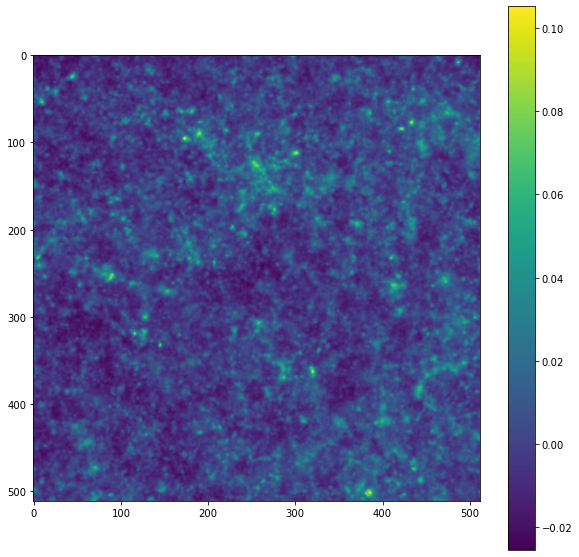

In [14]:
%pylab inline 
figure(figsize=[10,10])
imshow(m[0,:,:,3]); colorbar();

In [ ]:
ps = np.stack([DHOS.statistics.power_spectrum(m[0,:,:,i], field_size,field_npix)[1] for i in range(len(z_source))], axis=0)
l, _ = DHOS.statistics.power_spectrum(m[0,:,:,-1],field_size,field_npix)

Text(0.5, 0, '$\\ell$')

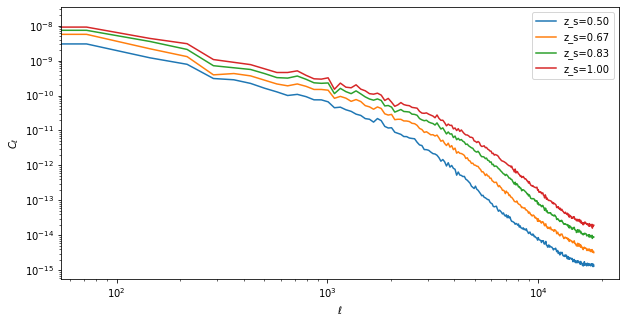

In [122]:
figure(figsize=[10,5])
for i in range(len(z_source)):
    loglog(l, ps[i], color="C%d"%i, label="z_s=%0.2f"%z_source[i])
legend()
ylabel('$C_\ell$')
xlabel('$\ell$')


Text(0.5, 0, '$\\ell$')

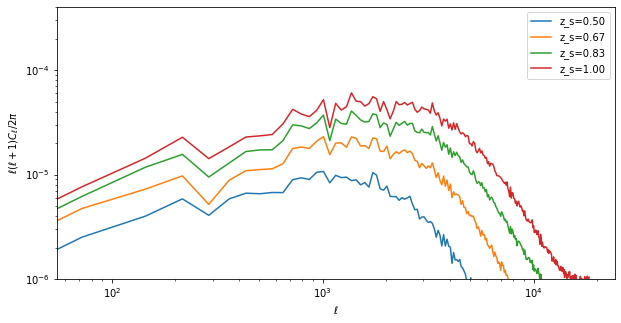

In [123]:
figure(figsize=[10,5])
for i in range(len(z_source)):
    loglog(l, l*(l+1)*ps[i]/(2*pi), color="C%d"%i, label="z_s=%0.2f"%z_source[i])
    
    

legend()
ylabel('$\ell(\ell+1)C_\ell /2\pi$')
ylim(1e-6,4e-4)
xlabel('$\ell$')
